In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

import keras
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Conv1D, Dense, Flatten, MaxPooling1D, Dropout, SimpleRNN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import math
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report

from keras.utils import plot_model
from IPython.display import Image

from matplotlib import pyplot as plt
np.random.seed(24)

### Data Preprocessing

In [ ]:
train = [] 
test = [] 
dev = [] 

In [ ]:
## Get sentences and their corresponding indexes from datasetSentences.txt and create a mapping(used dictionary here)

sentence_index_vs_sentence = {}

fp = open("/content/drive/MyDrive/stanfordSentimentTreebank/datasetSentences.txt","r")
lines = fp.readlines()
lines = lines[1:]

for line in lines:
  ids = line.split("\t")
  sentence_index_vs_sentence[ids[0]] = ids[1][:-1]

In [ ]:
## To know if a sentence belongs to test,train or dev we need to read datasetSplit.txt which has this mapping

sentence_index_vs_split = {}

fp = open("/content/drive/MyDrive/stanfordSentimentTreebank/datasetSplit.txt","r")
lines = fp.readlines()
lines = lines[1:]

for line in lines:
  ids = line.split(",")
  sentence_index_vs_split[ids[0]] = ids[1][:-1]

In [ ]:
## According to the above split divide the sentences into train, test and dev

for k in sentence_index_vs_split.keys():
  if sentence_index_vs_split[k]=='1':
    train.append(sentence_index_vs_sentence[k])
  elif sentence_index_vs_split[k]=='2':
    test.append(sentence_index_vs_sentence[k])
  elif sentence_index_vs_split[k]=='3':
    dev.append(sentence_index_vs_sentence[k])

In [ ]:
print("train:",len(train))
print("test: ",len(test))
print("dev: ",len(dev))

train: 8544
test:  2210
dev:  1101


__Observation__:

- Here we can observe that the length of train,test and dev are same as mentioned in the paper
- Hence, verified 

In [ ]:
## Get the individual sentence and their respective ID from dictionary.txt

sentence_vs_sentence_ids = {}

fp = open("/content/drive/MyDrive/stanfordSentimentTreebank/dictionary.txt","r")
lines = fp.readlines()


for line in lines:
  ids = line.split("|")
  # print(line)
  if len(ids)>2:
    sentence = '|'.join(ids[:-1])
    id = ids[-1]
  else:
    sentence = ids[0]
    id = ids[1]
  sentence_vs_sentence_ids[sentence] = id[:-1]

In [ ]:
## Get sentiment labels ranging from (0 to 1) which indicates the emotion from sentiment_labels.txt

sentiment_lbs = {}

fp = open("/content/drive/MyDrive/stanfordSentimentTreebank/sentiment_labels.txt","r")
lines = fp.readlines()
lines = lines[1:]

ids_vs_values = {}

for line in lines:
  ids = line.split("|")
  ids_vs_values[ids[0]] = float(ids[1][:-1])

In [ ]:
## Get the labels for each word or a sub-sentence from "sentence_vs_sentence_ids" 


sentences = list(sentence_vs_sentence_ids.keys())

test_sentiments_values = []
test_labels = []

for x in test:
  ids = x.split(" ")

  temp = []
  temp1 = []
  for i in ids:
    if i in sentences:
      temp.append(ids_vs_values[sentence_vs_sentence_ids[i]])
      temp1.append(i)
      
  test_sentiments_values.append(temp1)
  test_labels.append(np.mean(temp))

In [ ]:
## Same repeated for both train and dev

train_sentiments_values = []
train_labels = []

for x in train:
  ids = x.split(" ")
  temp = []
  temp1 = []
  for i in ids:
    if i in sentences:
      temp.append(ids_vs_values[sentence_vs_sentence_ids[i]])
      temp1.append(i)

  train_sentiments_values.append(temp1)
  train_labels.append(np.mean(temp))

In [ ]:
dev_sentiments_values = []
dev_labels = []

for x in train:
  ids = x.split(" ")
  temp = []
  temp1 = []
  for i in ids:
    if i in sentences:
      temp.append(ids_vs_values[sentence_vs_sentence_ids[i]])
      temp1.append(i)
      
  dev_sentiments_values.append(temp1)
  dev_labels.append(np.mean(temp))

In [ ]:
import itertools
data = list(itertools.chain(test_sentiments_values, train_sentiments_values, dev_sentiments_values))
labels = list(itertools.chain(test_labels, train_labels, dev_labels))

### Convert words to tokens

In [ ]:
MAX_NB_WORDS = 5000 ## Considering top 5000 most repeated words
MAX_SEQUENCE_LENGTH = 52 ## Highest number of words in a sentence 
trunc_type = 'post' 
padding_type = 'post'

def tokenize_data(input_arr):
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
  tokenizer.fit_on_texts(input_arr) 
  sequences = tokenizer.texts_to_sequences(input_arr)

  word_index = tokenizer.word_index

  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
  return data, word_index


## Get the sequences and word to index mapping 
data, word_index = tokenize_data(data) 

In [ ]:
trail = list(itertools.chain(test_sentiments_values, train_sentiments_values, dev_sentiments_values))
trail[0]

In [ ]:
data

array([[ 681,   14, 2283, ...,    0,    0,    0],
       [  45,   22,  262, ...,    0,    0,    0],
       [1158,   13,  114, ...,    0,    0,    0],
       ...,
       [  87,  192,  202, ...,    0,    0,    0],
       [ 111,  282, 2899, ...,    0,    0,    0],
       [  12,   18,  511, ...,    0,    0,    0]], dtype=int32)

In [ ]:
word_index.items() 

dict_items([('.', 1), ('the', 2), (',', 3), ('a', 4), ('and', 5), ('of', 6), ('to', 7), ('is', 8), ("'s", 9), ('it', 10), ('that', 11), ('in', 12), ('as', 13), ('but', 14), ('film', 15), ('with', 16), ('for', 17), ('this', 18), ('movie', 19), ('an', 20), ('its', 21), ('you', 22), ('be', 23), ("n't", 24), ('on', 25), ('...', 26), ('not', 27), ('by', 28), ('one', 29), ('about', 30), ('has', 31), ('are', 32), ('more', 33), ('--', 34), ('like', 35), ('at', 36), ('from', 37), ('than', 38), ('all', 39), ('have', 40), ('his', 41), ('i', 42), ("'", 43), ('so', 44), ('if', 45), ('or', 46), ('story', 47), ('-rrb-', 48), ('-lrb-', 49), ('what', 50), ('there', 51), ('who', 52), ('too', 53), ('does', 54), ('into', 55), ('just', 56), ('out', 57), ('most', 58), ('up', 59), ('much', 60), ('will', 61), ('good', 62), ('even', 63), ('no', 64), ('can', 65), ('comedy', 66), ("''", 67), ('``', 68), ('`', 69), ('some', 70), ('time', 71), ('characters', 72), ('he', 73), ('only', 74), ('their', 75), ('little',

In [ ]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(9455, 52)
(4053, 52)
(5790, 52)
(9455,)
(4053,)
(5790,)


### Embedding the test using GLove

In [ ]:
embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs 
f.close()

## Get the word to vector mapping from GLove 
print('Found %s word vectors.' % len(embeddings_index)) 

Found 400000 word vectors.


In [ ]:
EMBEDDING_DIM = 100 
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

## Generate word to vector mapping for the given data
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector 

In [ ]:
embedding_layer = Embedding(len(word_index) + 1, 
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH) 

### Training the Model

In [ ]:
model = Sequential() 
model.add(embedding_layer) 
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Dropout(0.7)) 
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))  
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',
              optimizer='adam') 
print(model.summary())

model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
          epochs=2, batch_size=1) 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 100)           1859100   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 52, 64)            32064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 26, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 64)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               132000    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 2,023,365
Trainable params: 164,265
Non-trainable params: 1,859,100
______________________________________

### Testing the model

In [ ]:
predicted = model.predict(x_test) 
default_error = math.sqrt(mean_squared_error(y_test, predicted))*100 

#Experiments
We will be performing some tweaks in the model to study the changes in performances

In [ ]:
x_axis = ["Default","Removing the Dropout"]
error_list = [default_error] 

## 1. Removing the dropout

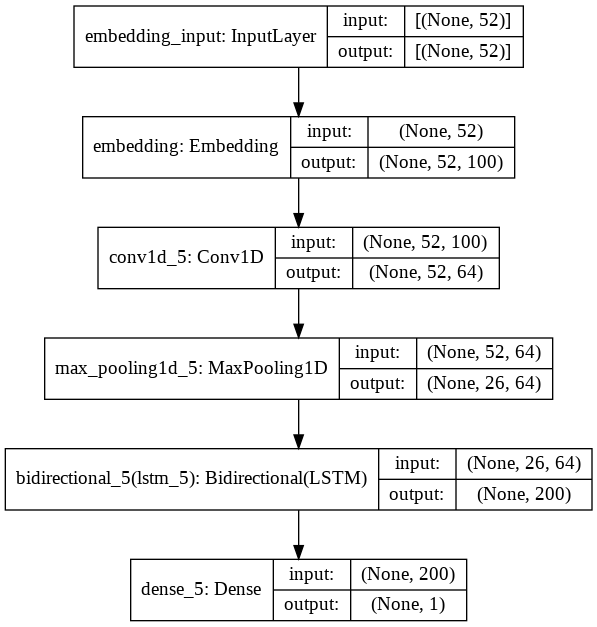

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(keras.layers.Bidirectional(LSTM(EMBEDDING_DIM))) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',
              optimizer='adam') 
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename="model.png")

In [ ]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=5, batch_size=1)
predicted = model.predict(x_test)
error = math.sqrt(mean_squared_error(y_test, predicted))*100
error_list.append(error)

Epoch 1/5
9455/9455 [==============================] - 76s 8ms/step - loss: 0.0016 - val_loss: 8.0166e-04
Epoch 2/5
9455/9455 [==============================] - 74s 8ms/step - loss: 4.8850e-04 - val_loss: 5.7627e-04
Epoch 3/5
9455/9455 [==============================] - 74s 8ms/step - loss: 3.9521e-04 - val_loss: 5.2799e-04
Epoch 4/5
9455/9455 [==============================] - 74s 8ms/step - loss: 3.5204e-04 - val_loss: 4.8836e-04
Epoch 5/5
9455/9455 [==============================] - 74s 8ms/step - loss: 3.0478e-04 - val_loss: 5.1592e-04


## 2. Increasing the number of filters

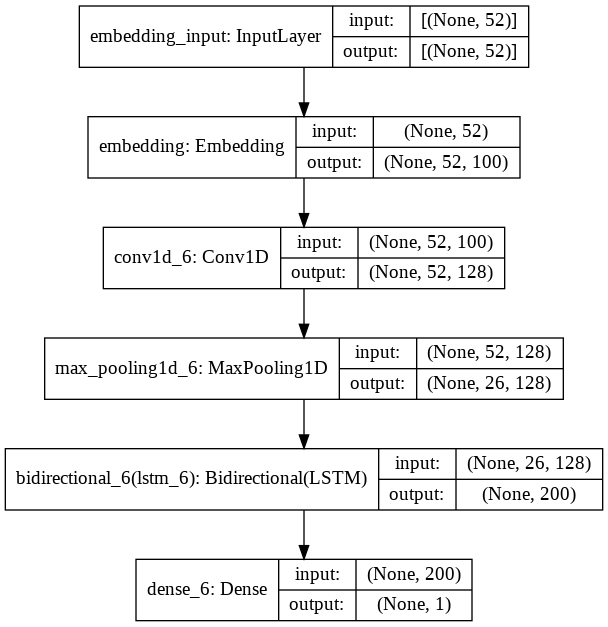

In [ ]:
x_axis.append("Increasing number of filters")
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(keras.layers.Bidirectional(LSTM(EMBEDDING_DIM))) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',
              optimizer='adam') 
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename="model.png")

In [ ]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=5, batch_size=128)
predicted = model.predict(x_test)
error = math.sqrt(mean_squared_error(y_test, predicted))*100
error_list.append(error)

Epoch 1/5
74/74 [==============================] - 4s 21ms/step - loss: 0.0371 - val_loss: 0.0017
Epoch 2/5
74/74 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 3/5
74/74 [==============================] - 1s 10ms/step - loss: 7.1014e-04 - val_loss: 9.3335e-04
Epoch 4/5
74/74 [==============================] - 1s 10ms/step - loss: 5.6451e-04 - val_loss: 7.8342e-04
Epoch 5/5
74/74 [==============================] - 1s 10ms/step - loss: 4.6763e-04 - val_loss: 7.0854e-04


## 3. Increasing the batch size with batch normalization

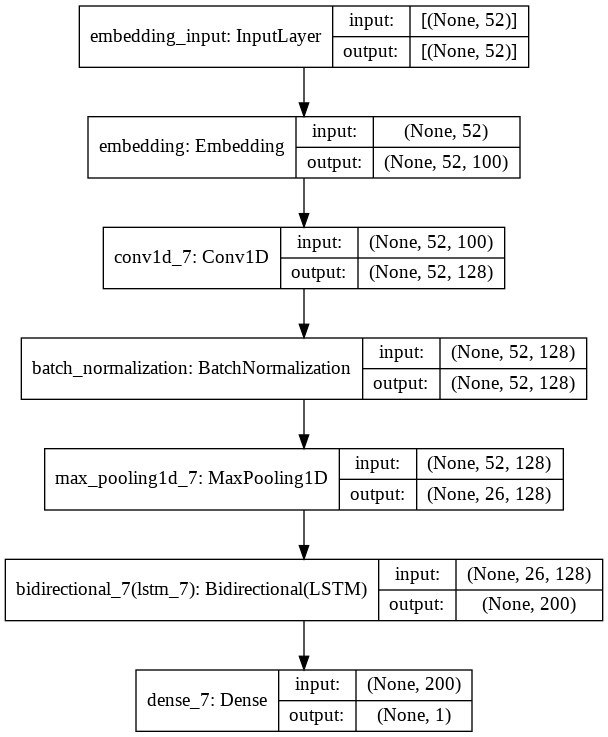

In [ ]:
x_axis.append("Batch size (with batch normalization)")
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal'))
model.add(keras.layers.BatchNormalization())
model.add(MaxPooling1D(pool_size=2)) 
model.add(keras.layers.Bidirectional(LSTM(EMBEDDING_DIM))) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',
              optimizer='adam') 
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename="model.png")

In [ ]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=5, batch_size=128)
predicted = model.predict(x_test)
error = math.sqrt(mean_squared_error(y_test, predicted))*100
error_list.append(error) 

Epoch 1/5
74/74 [==============================] - 4s 20ms/step - loss: 0.1227 - val_loss: 0.0478
Epoch 2/5
74/74 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0159
Epoch 3/5
74/74 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 4/5
74/74 [==============================] - 1s 11ms/step - loss: 9.6114e-04 - val_loss: 0.0019
Epoch 5/5
74/74 [==============================] - 1s 11ms/step - loss: 8.1582e-04 - val_loss: 0.0016


## 4. Increasing the batch size without batch normalization

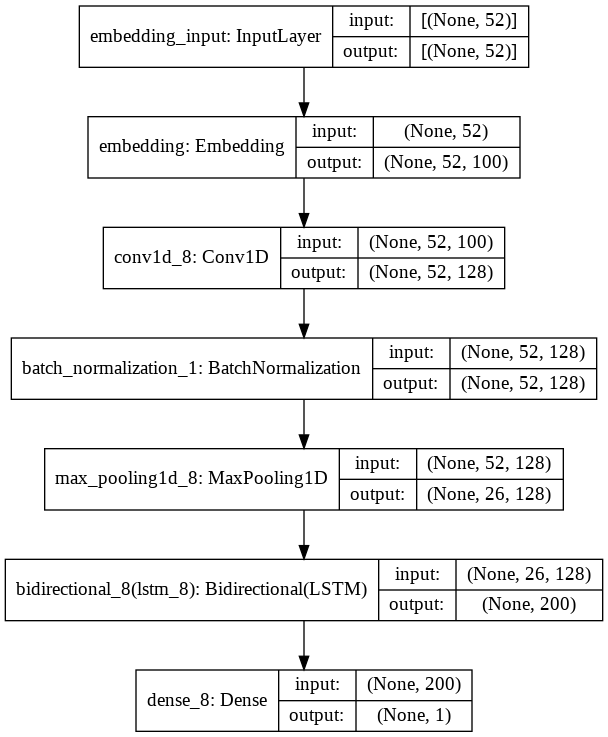

In [ ]:
x_axis.append("Batch size (without batch normalization)")
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal'))
model.add(keras.layers.BatchNormalization())
model.add(MaxPooling1D(pool_size=2)) 
model.add(keras.layers.Bidirectional(LSTM(EMBEDDING_DIM))) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',
              optimizer='adam') 
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename="model.png")

In [ ]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=5, batch_size=128)
predicted = model.predict(x_test)
error = math.sqrt(mean_squared_error(y_test, predicted))*100
error_list.append(error)

Epoch 1/5
74/74 [==============================] - 4s 20ms/step - loss: 0.1200 - val_loss: 0.1203
Epoch 2/5
74/74 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0481
Epoch 3/5
74/74 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0170
Epoch 4/5
74/74 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 5/5
74/74 [==============================] - 1s 11ms/step - loss: 9.4085e-04 - val_loss: 0.0041


## 5. Adding one more convolutiounal layer

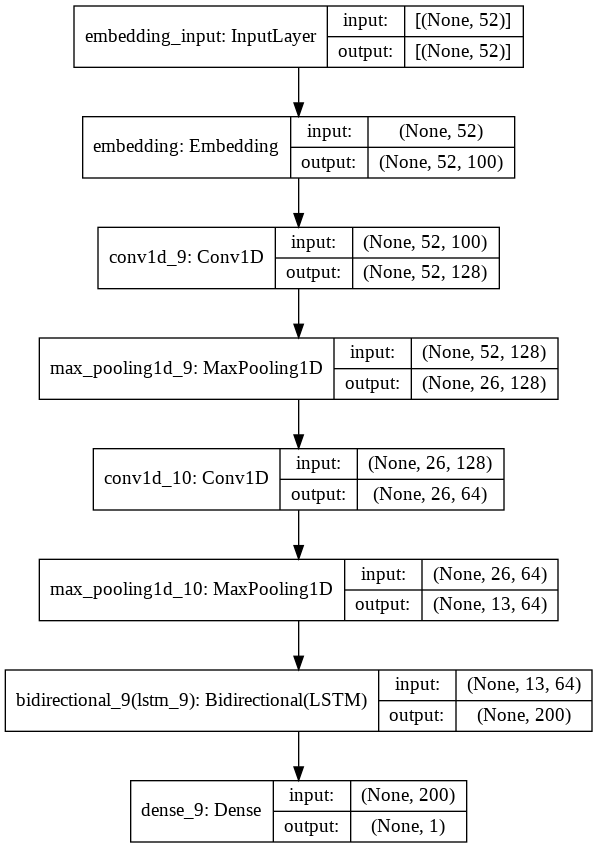

In [ ]:
x_axis.append("Adding one more convolutional layer")
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(keras.layers.Bidirectional(LSTM(EMBEDDING_DIM))) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', 
              optimizer='adam') 
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename="model.png")

In [ ]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=5, batch_size=1)
predicted = model.predict(x_test)
error = math.sqrt(mean_squared_error(y_test, predicted))*100
error_list.append(error)

Epoch 1/5
9455/9455 [==============================] - 70s 7ms/step - loss: 0.0035 - val_loss: 7.2757e-04
Epoch 2/5
9455/9455 [==============================] - 67s 7ms/step - loss: 5.4884e-04 - val_loss: 6.1968e-04
Epoch 3/5
9455/9455 [==============================] - 67s 7ms/step - loss: 4.0484e-04 - val_loss: 5.6471e-04
Epoch 4/5
9455/9455 [==============================] - 67s 7ms/step - loss: 3.4120e-04 - val_loss: 4.5213e-04
Epoch 5/5
9455/9455 [==============================] - 67s 7ms/step - loss: 3.0702e-04 - val_loss: 4.6359e-04


## 6. Using normal LSTM without Bi-directional LSTM

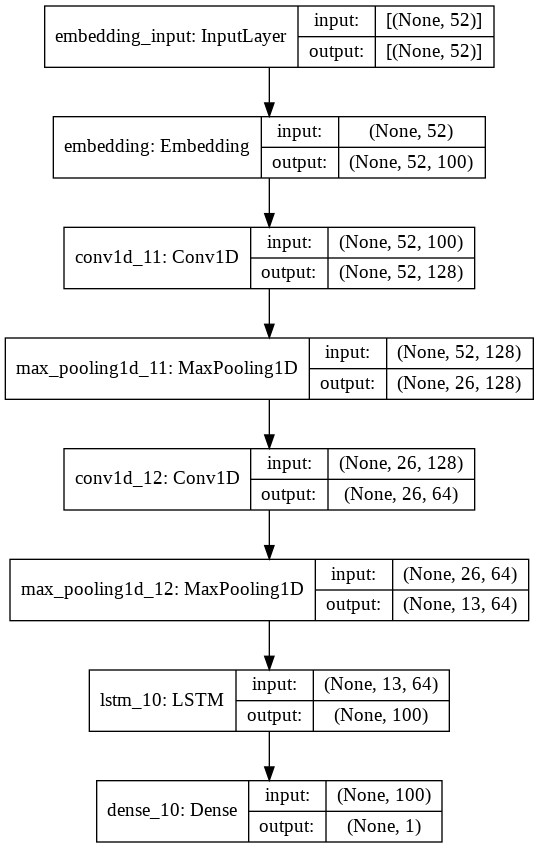

In [ ]:
x_axis.append("Removing bidirectionality of LSTM")
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(LSTM(EMBEDDING_DIM))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',
              optimizer='adam') 
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename="model.png")

In [ ]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=5, batch_size=1)
predicted = model.predict(x_test)
error = math.sqrt(mean_squared_error(y_test, predicted))*100
error_list.append(error)

Epoch 1/5
9455/9455 [==============================] - 48s 5ms/step - loss: 0.0024 - val_loss: 5.8234e-04
Epoch 2/5
9455/9455 [==============================] - 46s 5ms/step - loss: 4.9334e-04 - val_loss: 5.4608e-04
Epoch 3/5
9455/9455 [==============================] - 46s 5ms/step - loss: 3.9402e-04 - val_loss: 4.8280e-04
Epoch 4/5
9455/9455 [==============================] - 46s 5ms/step - loss: 3.5199e-04 - val_loss: 4.8062e-04
Epoch 5/5
9455/9455 [==============================] - 46s 5ms/step - loss: 3.0791e-04 - val_loss: 4.5249e-04


##Plotting the finding

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_axis, error_list, 0.23)
plt.xlabel("Changes in the model") 
plt.ylabel("MSE Error")
plt.title("MSE vs Changes in model (5 epochs)")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
) 
plt.show() 

In [ ]:
x_axis.pop()
x_axis.pop() 
error_list.pop()